In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import secrets

In [2]:
# Create an EV class with the following attributes:
# - Brand
# - Model
# - Battery type
# - Battery size
# - Charging Efficiency
# - Discharging Efficiency
# - Energy per km
# - SOC min
# - SOC max
# - Probability in population - this is the probability that a car of this type will be chosen from the population

class EV:
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population):
        self.brand = brand
        self.model = model
        self.battery_type = battery_type
        self.battery_size = battery_size
        self.charging_efficiency = charging_efficiency if charging_efficiency <= 1 or charging_efficiency >= 0 else 0.9
        self.discharging_efficiency = discharging_efficiency if discharging_efficiency <= 1 or discharging_efficiency >= 0 else 0.9
        self.energy_per_km = energy_per_km
        self.soc_min = soc_min if soc_min >= 0.0 else 0.0
        self.soc_max = soc_max if soc_max <= 1.0 else 1.0
        self.probability_in_population = probability_in_population if probability_in_population <= 1.0 else 1.0


# Extend the class to create drivable EVs
class DrivableEV(EV):

    # __init__ method is inherited from EV class, extended with the state of charge. Creates the following attributes:
    # - State of Charge
    # - List of trips
    # - Current trip
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, initial_soc=None):
        super().__init__(brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population)

        # EV ID
        self.ev_id = secrets.token_hex(16)

        # SOC variables
        self.soc = [initial_soc]
        self.current_soc = initial_soc

        # List of trips and current trip
        self.trips = []
        self.current_trip = None

        # Information about the charging stations
        self.current_charging_station = None

        # EV driving status
        self.driving_status = 'Idle'


    # Format the print
    def __repr__(self):
        return f"{self.brand} {self.model} with {self.battery_size} kWh battery"

    # Create a method to add a trip to the EV
    def add_trip(self, trip):
        self.trips.append(trip)


    # Create a method to charge the EV
    def charge(self, charge_amount):
        self.current_soc += charge_amount * self.charging_efficiency

        if self.current_soc > self.battery_size:
            self.current_soc = self.battery_size


    # Create a method to discharge the EV
    def discharge(self, discharge_amount):
        self.current_soc -= discharge_amount * self.discharging_efficiency

        if self.current_soc < 0:
            self.current_soc = 0


    # Create a method to update the state of charge according to current trip length
    def update_soc(self):
        self.current_soc -= self.current_trip.length * self.energy_per_km * self.discharging_efficiency

        if self.current_soc < 0:
            self.current_soc = 0



In [3]:
# Define a Trip class, that will assign a trip to an EV. Has the following parameters:
# - EV
# - Trip length
# - Trip start time (can be a range)
# - Trip end time (can be a range)
# - Trip start SOC
# - Trip end SOC
# - Trip energy consumption
# - Trip stops

class Trip:
    def __init__(self, trip_length, trip_start_time, trip_end_time, trip_duration):
        self.trip_length = trip_length
        self.trip_start_time = trip_start_time
        self.trip_end_time = trip_end_time
        self.trip_duration = trip_duration


class DrivableTrip(Trip):
    # Init method is the same as Trip class
    def __init__(self, trip_length, trip_start_time, trip_end_time, trip_duration, profile=None):
        super().__init__(trip_length, trip_start_time, trip_end_time, trip_duration)

        # Information about EV
        self.ev = None
        self.ev_id = None

        # Information about the trip
        self.trip_energy_consumption = None
        self.trip_required_soc = None
        self.covered_trip_length = None
        self.ev_battery_size = None
        self.trip_stops = []
        self.trip_estimate_arrival = trip_end_time
        self.profile = profile

        # Completed trips
        self.trip_status = 'Not started'


    # Formatted print method
    def __repr__(self):
        return f'Trip length: {self.trip_length} km, trip start time: {self.trip_start_time}, ' \
               f'trip end time: {self.trip_end_time}, trip energy consumption: {self.trip_energy_consumption} kWh, ' \
               f'trip required SOC: {self.trip_required_soc} %, trip stops: {self.trip_stops}'

    # Create a method to calculate the trip energy consumption
    def calculate_trip_energy_consumption(self):
        self.trip_energy_consumption = self.trip_length * self.ev.energy_per_km


    # Create a method to calculate the trip required SOC
    def calculate_trip_required_soc(self):
        self.trip_required_soc = self.trip_energy_consumption / self.ev.battery_size


    # Create a method to assign the battery size of the EV to the trip
    def assign_ev_battery_size(self):
        self.ev_battery_size = self.ev.battery_size


    # Create a method to add stops to the trip
    def add_stop(self, stop):
        self.trip_stops.append(stop)


    # Create a method to update the covered trip length
    def update_covered_trip_length(self, covered_trip_length):
        self.covered_trip_length += covered_trip_length


    # Create a method to update the required SOC
    def update_trip_required_soc(self):
        self.trip_required_soc = (self.trip_energy_consumption - self.covered_trip_length * self.ev.energy_per_km) / self.ev.battery_size


In [4]:
# Define a Charging Station class, that will charge the EVs. Has the following parameters:
# - Charging station name
# - Charging station location
# - Charging station type
# - Charging station power
# - Charging station efficiency
# - Charging station availability
# - Charging station cost

class ChargingStation:
    def __init__(self, charging_station_type, charging_station_power, charging_station_efficiency, charging_station_cost):
        # Parameters Assign
        self.charging_station_type = charging_station_type
        self.charging_station_power = charging_station_power
        self.charging_station_cost = charging_station_cost
        self.charging_station_efficiency = charging_station_efficiency

        # Information about the charging station
        self.charging_station_name = None
        self.charging_station_location = None
        self.charging_station_availability = None

    # Method to set the name of the charging station
    def set_charging_station_name(self, charging_station_name):
        self.charging_station_name = charging_station_name

    # Method to set the location of the charging station
    def set_charging_station_location(self, charging_station_location):
        self.charging_station_location = charging_station_location

    # Method to set the availability of the charging station to either True or False
    def set_charging_station_availability(self, charging_station_availability):
        self.charging_station_availability = charging_station_availability.astype(bool)


In [5]:
# Define a User class, that will have the following parameters:
# - User name
# - User location
# - User trips
# - User EV
# - User type

class User:
    def __init__(self, user_name, user_profile):
        # Parameters Assign
        self.user_name = user_name
        self.user_profile = user_profile

    # Method to assign an EV to the user
    def assign_ev(self, ev):
        self.user_ev = ev


# Create a Profile class that will determine the behaviour of the Users. Has the following parameters:
# - Profile name
# - Profile type
# - Profile trip schedule
# - Trip type
class Profile:
    def __init__(self, profile_name, trip_type, profile_trip_schedule):
        # Parameters Assign
        self.profile_name = profile_name
        self.trip_type = trip_type
        self.profile_trip_schedule = profile_trip_schedule

    # Format printing
    def __repr__(self):
        return f'N:{self.profile_name}, T:{self.trip_type}'


# Create a Schedule class with the following parameters:
# - Schedule start
# - Schedule end
class Schedule:
    def __init__(self, schedule_start, schedule_end):
        # Parameters Assign
        self.schedule_start = schedule_start
        self.schedule_end = schedule_end

    # Format printing
    def __repr__(self):
        return f'Schedule start: {self.schedule_start}, schedule end: {self.schedule_end}'

In [20]:
 # Define an Aggregator class, that will aggregate the trips and EVs. Has the following parameters:
# - EVs
# - Number of EVs
class Aggregator:
    def __init__(self, profiles, evs, charging_stations):
        # Profile assign
        self.profiles = profiles

        # Assign the EVs to the aggregator
        self.evs = evs

        # Number of EVs of the simulation
        self.number_of_evs = None

        # Create a list of trips
        self.trips = []
        self.segments = []
        self.population = None
        self.assigned_evs = []

        # Assign the charging stations to the aggregator
        self.charging_stations = charging_stations

    # Add an EV to the fleet
    def add_ev(self, ev):
        self.evs.append(ev)

    # Assign a trip to an EV
    def assign_trip(self, ev, trip):
        ev.add_trip(trip)

    # Assign a charging station to an EV, and charge the EV if:
    # - The charging station is available
    # - The charging station is of the correct type
    # - The charging station has enough power to charge the EV
    def assign_charging_station(self, ev, charging_station):
        if charging_station.charging_station_availability == True and charging_station.charging_station_type == ev.battery_type and charging_station.charging_station_power >= ev.battery_size:
            ev.current_charging_station = charging_station
            ev.charge(charging_station.charging_station_power)
            charging_station.charging_station_availability = False


    # Create the population of DrivableEVs according to NumPy's random.choice
    def create_evs(self, n_evs):
        # Assign the number of EVs to the aggregator
        self.number_of_evs = n_evs

        # Create an EV population according to the given probabilities of the EVs
        population_choice = np.random.choice(self.evs, n_evs,
                                             p=[ev.probability_in_population for ev in self.evs])

        # Create a list of DrivableEVs
        self.population = [DrivableEV(ev.brand, ev.model, ev.battery_type, ev.battery_size,
                                      ev.charging_efficiency, ev.discharging_efficiency,
                                      ev.energy_per_km, ev.soc_min, ev.soc_max,
                                      ev.probability_in_population,
                                      initial_soc=np.round(np.random.uniform(ev.soc_min,
                                                                             ev.soc_max, 1)[0], 2))
                           for ev in population_choice]


    # Create DrivableTrips with gamma distribution for the trip length
    # Create a gamma distribution for the trip length
    def create_trips(self, n_trips, avg_speed, medium_trip_min=50, medium_trip_max=100):
        shape, scale = 41.*.035, 41.*2
        trip_lengths = np.round(np.random.gamma(shape, scale, n_trips), 2)

        # Assign the trip lengths to the trips list
        self.trips = [Trip(trip_length, None, None, None) for trip_length in trip_lengths]

        # Create the DrivableTrips
        for trip in range(n_trips):

            # Calculate trip type based on distance
            trip_type = 'Short' if trip_lengths[trip] <= medium_trip_min else 'Medium' if medium_trip_min < trip_lengths[trip] <= medium_trip_max else 'Long'

            # Get the user profiles that match the trip type
            user_profiles = [profile for profile in self.profiles if profile.trip_type == trip_type]

            # Get the user profile based on the user profiles that match the trip type
            user_profile = np.random.choice(user_profiles, 1)[0]

            # Check how many trips the user has
            user_trips = len(user_profile.profile_trip_schedule)

            # If there are more than 1 trip, split into multiple trips
            if user_trips > 1:

                # Placeholder for list of segments of each trip. Each segment is a DrivableTrip
                segment_list = []

                # Calculate the required socs for trip segment
                for i in range(user_trips):
                    # Get the start and end of the trip segment
                    segment_start = user_profile.profile_trip_schedule[i].schedule_start
                    segment_end = user_profile.profile_trip_schedule[i].schedule_end

                    # Calculate the segment length
                    duration = segment_end - segment_start if segment_end > segment_start else 0

                    # Calculate the segment distance
                    distance = duration * avg_speed

                    # Create a DrivableTrip for each segment
                    segment_list.append(DrivableTrip(distance, segment_start, segment_end, duration, profile=user_profile))

                # Append to the trips list
                self.segments.append(segment_list)

            elif user_trips == 1:
                # Calculate the trip duration
                trip_duration = user_profile.profile_trip_schedule[0].schedule_end - user_profile.profile_trip_schedule[0].schedule_start

                # Create a DrivableTrip for the trip
                drivable_trip = DrivableTrip(trip_lengths[trip],
                                             user_profile.profile_trip_schedule[0].schedule_start,
                                             user_profile.profile_trip_schedule[0].schedule_end, trip_duration, profile=user_profile)

                # Append to the segments list
                self.segments.append([drivable_trip])


    # Create DrivableTrips with a gamma distribution for the trip length
    def create_trips_old(self, n_trips, start_period, end_period, avg_speed):

        # Create a gamma distribution for the trip length
        shape, scale = 41.*.035, 41.*2
        trip_lengths = np.round(np.random.gamma(shape, scale, n_trips), 2)

        # Create the DrivableTrips
        for trip in range(n_trips):
            # Calculate trip duration based on trip length and average speed
            trip_duration = np.ceil(trip_lengths[trip] / avg_speed)

            # Create a trip starting time
            trip_start_time = np.random.randint(start_period, end_period)
            trip_start_time = trip_start_time if trip_start_time + trip_duration <= end_period else trip_start_time - trip_duration

            # Create a trip ending time
            trip_end_time = trip_start_time + trip_duration

            # Create the DrivableTrip object
            drivable_trip = DrivableTrip(trip_lengths[trip], trip_start_time, trip_end_time, trip_duration)
            self.trips.append(drivable_trip)


    # Assign the larger trips to the EVs with larger battery sizes with a greater probability
    def assign_trips(self):
        # Create a copy of the population
        population_copy = copy.deepcopy(self.population)
        segments_copy = copy.deepcopy(self.segments)

        # Assigned EVs and Trips
        assigned_evs = []

        # Create a list with the probabilities of the EVs to get a trip
        probabilities = [ev.battery_size / sum([ev.battery_size for ev in self.population]) for ev in population_copy]

        # Sort the segments by trip length and assign it to a temporary variable
        sorted_segments = sorted(segments_copy, key=lambda x: x[0].trip_length, reverse=True)

        # Assign the sorted trips to the EVs
        for segment in sorted_segments:
            # Choose an EV from the population
            ev = np.random.choice(population_copy, 1, p=probabilities)[0]

            for trip in segment:
                # Assign the trip segments to the EV
                trip.ev = ev
                trip.ev_id = ev.ev_id
                trip.calculate_trip_energy_consumption()
                trip.calculate_trip_required_soc()
                trip.assign_ev_battery_size()

                # Add the trip to the EV
                ev.add_trip(trip)

                # Calculate the trip energy consumption and required SOC
                trip.calculate_trip_energy_consumption()
                trip.calculate_trip_required_soc()

            # Remove the EV from the population
            population_copy.remove(ev)

            self.assigned_evs.append(ev)

            # Recalculate the probabilities
            probabilities = [ev.battery_size / sum([ev.battery_size for ev in population_copy]) for ev in population_copy]

            # If the population is empty, break the loop
            if len(population_copy) == 0:
                break


    # Create the charging stations
    def create_cs(self, n_cs):
        # Create a list of charging stations
        charging_stations = []

        # Create the charging stations
        for cs in range(n_cs):

            # Create a charging station type
            charging_station_type = np.random.choice(["Lithium-Ion", "Lead-Acid", "Nickel-Metal Hydride"])

            # Create a charging station power
            charging_station_power = np.random.randint(100, 1000)

            # Create a charging station efficiency
            charging_station_efficiency = np.random.uniform(0.8, 0.95)

            # Create a charging station cost
            charging_station_cost = np.random.randint(100, 1000)

            # Create the charging station object
            charging_station = ChargingStation(charging_station_type, charging_station_power, charging_station_efficiency, charging_station_cost)

            # Add the charging station to the list
            charging_stations.append(charging_station)

        # Assign the charging stations to the aggregator
        self.charging_stations = charging_stations


    # Add a stop to the trip and EVs when:
    # if required SOC is > 1.0;
    # required SOC > current SOC;
    # current SOC <= 0.2
    def add_stop(self):
        # Check population for need to add a stop
        for ev in self.population:
            # Check if the trip requires a stop
            if ev.trips[-1].required_soc > 1.0 or ev.trips[-1].required_soc > ev.soc or ev.soc <= 0.2:

                # Create a list with available charging stations
                available_charging_stations = [cs for cs in self.charging_stations if cs.charging_station_availability == True]

                # If there are available stations, attribute the first to the EV
                ev.trip.add_stop(available_charging_stations[0])

                # Charge the EV
                ev.charge(ev.current_charging_station.charging_station_power)

                # Update the charging station availability
                ev.current_charging_station.charging_station_availability = False


    # Run the simulation
    def run_sim(self):
        # Update the EVs SOC according to covered trip length
        # Check if there are trips to be covered
        for user in self.users:
            pass


    # Create a DataFrame of the population
    def population_dataframe(self):
        # Create a DataFrame of the population
        population_dataframe = pd.DataFrame([ev.__dict__ for ev in self.population])

        # Return the DataFrame
        return population_dataframe


    # Create a DataFrame of assigned EVs
    def assigned_evs_dataframe(self):
        # Create a DataFrame of the population
        assigned_evs_dataframe = pd.DataFrame([ev.__dict__ for ev in self.assigned_evs])

        # Return the DataFrame
        return assigned_evs_dataframe


    # Create a DataFrame of the trips
    def assigned_trips_dataframe(self):
        # Create a DataFrame of the trips
        trips_dataframe = pd.DataFrame([trip.trip_length for trip in self.trips])
        trips_dataframe.columns = ["trip_length"]

        # Return the DataFrame
        return trips_dataframe


    # Create a DataFrame of assigned Trips and all the information in the list
    def assigned_segments_dataframe(self):
        # Create a DataFrame of the population
        assigned_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.assigned_evs for trip in ev.trips])

        # Return the DataFrame
        return assigned_trips_dataframe

In [21]:
# Create a list of EVs to use in the simulation

EVs = [EV(brand='Nissan', model='Leaf', battery_type='BEV', battery_size=59,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.16, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Tesla', model='Model 3', battery_type='BEV', battery_size=95,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.13, energy_per_km=0.18, soc_min=0.7, soc_max=1.0),
       EV(brand='Peugeot', model='e-Expert', battery_type='BEV', battery_size=68,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.26, soc_min=0.7, soc_max=1.0),
       EV(brand='Renault', model='Zoe', battery_type='BEV', battery_size=52,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Jaguar', model='I-Pace', battery_type='BEV', battery_size=85,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.09, energy_per_km=0.22, soc_min=0.7, soc_max=1.0),
       EV(brand='Mercedes', model='E300', battery_type='PHEV', battery_size=13.5,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.18, soc_min=0.7, soc_max=1.0),
       EV(brand='BMW', model='530e', battery_type='PHEV', battery_size=70.2,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.16, soc_min=0.7, soc_max=1.0),
       EV(brand='Audi Q4', model='e-tron', battery_type='PHEV', battery_size=55,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.07, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Hyundai', model='Kauai', battery_type='BEV', battery_size=74,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.06, energy_per_km=0.192, soc_min=0.7, soc_max=1.0),
       EV(brand='Volvo', model='XC40', battery_type='PHEV', battery_size=78,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.176, soc_min=0.7, soc_max=1.0),
       EV(brand='Wolkswagen', model='ID.3', battery_type='PHEV', battery_size=58,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.155, soc_min=0.7, soc_max=1.0),
       EV(brand='Others', model='Others', battery_type='PEV', battery_size=20,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.03, energy_per_km=0.2, soc_min=0.7, soc_max=1.0)]

# Print the sum of the probabilities in the population of EVs
sum_of_probabilities = 0
for ev in EVs:
    sum_of_probabilities += ev.probability_in_population
print(sum_of_probabilities)

1.0


In [22]:
# Create a list of Charging Stations to use in the simulation

CS = [ChargingStation(charging_station_type='Slow',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15),
      ChargingStation(charging_station_type='Slow',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15)]

In [23]:
# Create the profiles to use in the simulation

# Create a list of profiles
PROFILES = [Profile(profile_name='Residential', profile_trip_schedule=[Schedule(8, 9), Schedule(16, 17)], trip_type='Short'),
            Profile(profile_name='Residential', profile_trip_schedule=[Schedule(5, 8), Schedule(18, 23)], trip_type='Medium'),
            Profile(profile_name='Shopping', profile_trip_schedule=[Schedule(8, 10), Schedule(18, 20)], trip_type='Short'),
            Profile(profile_name='Work', profile_trip_schedule=[Schedule(8, 20)], trip_type='Long')]

In [24]:
# Create an Aggregator object
aggregator = Aggregator(profiles=PROFILES, evs=EVs, charging_stations=CS)

# Create the population of EVs
aggregator.create_evs(n_evs=100)

# Create the trips
aggregator.create_trips(n_trips=100,
                        avg_speed=60)

# Assign the EVs to the trips and calculate the trip energy consumption and required SOC.
# Also, assign the trip to the EV
aggregator.assign_trips()

In [25]:
# Print the population
aggregator.population_dataframe()

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,ev_id,soc,current_soc,trips,current_trip,current_charging_station,driving_status
0,Wolkswagen,ID.3,PHEV,58.0,0.9,0.9,0.155,0.7,1.0,0.05,2569b6e91150f8b29ef631bda93c3e34,[0.81],0.81,[],None,None,Idle
1,Jaguar,I-Pace,BEV,85.0,0.9,0.9,0.220,0.7,1.0,0.09,01b6e238544ff95cf980f7ee0b60f328,[0.74],0.74,[],None,None,Idle
2,Audi Q4,e-tron,PHEV,55.0,0.9,0.9,0.170,0.7,1.0,0.07,aa58684c27f19c7998f52ff21a311957,[0.75],0.75,[],None,None,Idle
3,Peugeot,e-Expert,BEV,68.0,0.9,0.9,0.260,0.7,1.0,0.10,6655375f98c077888d9511964dfb2f50,[0.86],0.86,[],None,None,Idle
4,Peugeot,e-Expert,BEV,68.0,0.9,0.9,0.260,0.7,1.0,0.10,b3e19ac1972a47e29fb5ad574fda50af,[0.81],0.81,[],None,None,Idle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Mercedes,E300,PHEV,13.5,0.9,0.9,0.180,0.7,1.0,0.08,5f9d17f3ce7b7fa5b9fb989d46a12d27,[0.81],0.81,[],None,None,Idle
96,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.7,1.0,0.16,9490d403d782bd01cb54471bc0fb8e05,[0.96],0.96,[],None,None,Idle
97,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.7,1.0,0.16,c79028171579e0eabb9afb7afb79b47e,[0.74],0.74,[],None,None,Idle
98,Peugeot,e-Expert,BEV,68.0,0.9,0.9,0.260,0.7,1.0,0.10,28a371e40bd62bab6265937ca757a01b,[0.94],0.94,[],None,None,Idle


In [26]:
# Print the assigned EVs

aggregator.assigned_evs_dataframe()

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,ev_id,soc,current_soc,trips,current_trip,current_charging_station,driving_status
0,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.7,1.0,0.13,2a17203ae8478f4320a4a4376b96da6f,[0.72],0.72,"[Trip length: 366.26 km, trip start time: 8, t...",None,None,Idle
1,Renault,Zoe,BEV,52.0,0.9,0.9,0.170,0.7,1.0,0.10,610614658c32fd36986a2ab3d22bb355,[0.8],0.80,"[Trip length: 338.35 km, trip start time: 8, t...",None,None,Idle
2,Wolkswagen,ID.3,PHEV,58.0,0.9,0.9,0.155,0.7,1.0,0.05,cb9f5f5321bef3bc48dbb9b06b395ea9,[0.83],0.83,"[Trip length: 300.5 km, trip start time: 8, tr...",None,None,Idle
3,Wolkswagen,ID.3,PHEV,58.0,0.9,0.9,0.155,0.7,1.0,0.05,af8752325bcc767e4e1b6f209acb297e,[0.86],0.86,"[Trip length: 274.09 km, trip start time: 8, t...",None,None,Idle
4,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.7,1.0,0.13,aa6a9547719e2b88368507d68516ed61,[0.8],0.80,"[Trip length: 255.76 km, trip start time: 8, t...",None,None,Idle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Mercedes,E300,PHEV,13.5,0.9,0.9,0.180,0.7,1.0,0.08,973c348dfbf541dfca29939426ba8022,[0.81],0.81,"[Trip length: 60 km, trip start time: 8, trip ...",None,None,Idle
96,Audi Q4,e-tron,PHEV,55.0,0.9,0.9,0.170,0.7,1.0,0.07,a7eb9ab563847bd055004a3f6a22e5c9,[0.98],0.98,"[Trip length: 60 km, trip start time: 8, trip ...",None,None,Idle
97,Mercedes,E300,PHEV,13.5,0.9,0.9,0.180,0.7,1.0,0.08,9d3da588755d9a55325338d25c69a482,[0.93],0.93,"[Trip length: 60 km, trip start time: 8, trip ...",None,None,Idle
98,Mercedes,E300,PHEV,13.5,0.9,0.9,0.180,0.7,1.0,0.08,c552a08b421f3a94aae326baf6e84691,[0.94],0.94,"[Trip length: 60 km, trip start time: 8, trip ...",None,None,Idle


In [27]:
# Print the trips

aggregator.assigned_trips_dataframe()

,trip_length
0,126.36
1,62.82
2,142.53
3,1.40
4,165.66
...,...
95,166.68
96,9.14
97,30.49
98,204.82


In [28]:
# Print trip segments

aggregator.assigned_segments_dataframe()

,trip_length,trip_start_time,trip_end_time,trip_duration,ev,ev_id,trip_energy_consumption,trip_required_soc,covered_trip_length,ev_battery_size,trip_stops,trip_estimate_arrival,profile,trip_status
0,366.26,8,20,12,Tesla Model 3 with 95 kWh battery,2a17203ae8478f4320a4a4376b96da6f,65.92680,0.693966,None,95.0,[],20,"N:Work, T:Long",Not started
1,338.35,8,20,12,Renault Zoe with 52 kWh battery,610614658c32fd36986a2ab3d22bb355,57.51950,1.106144,None,52.0,[],20,"N:Work, T:Long",Not started
2,300.50,8,20,12,Wolkswagen ID.3 with 58 kWh battery,cb9f5f5321bef3bc48dbb9b06b395ea9,46.57750,0.803060,None,58.0,[],20,"N:Work, T:Long",Not started
3,274.09,8,20,12,Wolkswagen ID.3 with 58 kWh battery,af8752325bcc767e4e1b6f209acb297e,42.48395,0.732482,None,58.0,[],20,"N:Work, T:Long",Not started
4,255.76,8,20,12,Tesla Model 3 with 95 kWh battery,aa6a9547719e2b88368507d68516ed61,46.03680,0.484598,None,95.0,[],20,"N:Work, T:Long",Not started
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,60.00,16,17,1,Mercedes E300 with 13.5 kWh battery,9d3da588755d9a55325338d25c69a482,10.80000,0.800000,None,13.5,[],17,"N:Residential, T:Short",Not started
143,60.00,8,9,1,Mercedes E300 with 13.5 kWh battery,c552a08b421f3a94aae326baf6e84691,10.80000,0.800000,None,13.5,[],9,"N:Residential, T:Short",Not started
144,60.00,16,17,1,Mercedes E300 with 13.5 kWh battery,c552a08b421f3a94aae326baf6e84691,10.80000,0.800000,None,13.5,[],17,"N:Residential, T:Short",Not started
145,60.00,8,9,1,Mercedes E300 with 13.5 kWh battery,e8d839db1cb3b8562893abc1fb614ffa,10.80000,0.800000,None,13.5,[],9,"N:Residential, T:Short",Not started


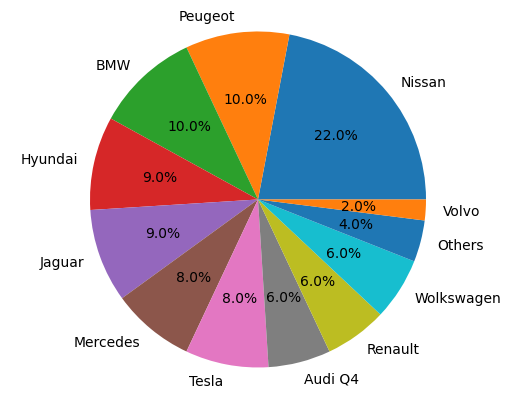

In [274]:
# Plot the population brand in a pie chart

# Values of each group
brand_values = aggregator.population_dataframe()['brand'].value_counts()
plt.pie(brand_values, labels=brand_values.index, autopct='%1.1f%%')

# View the plot
plt.axis('equal')
plt.show()

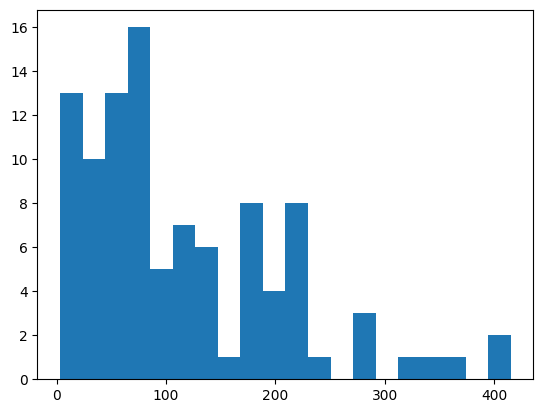

In [275]:
# Plot the trip distances in a histogram
plt.hist(aggregator.assigned_trips_dataframe()['trip_length'], bins=20)
plt.show()

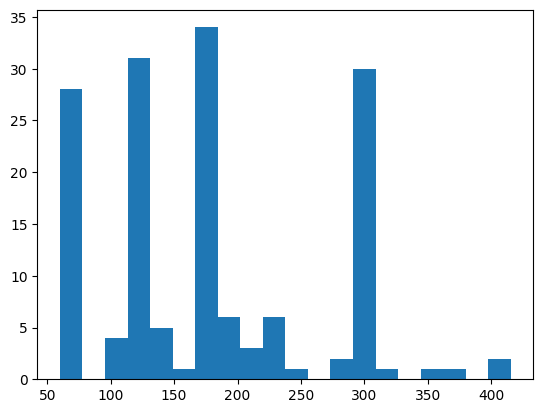

In [276]:
# Plot the segment distances in a histogram
plt.hist(aggregator.assigned_segments_dataframe()['trip_length'], bins=20)
plt.show()